In [1]:
import numpy as np
import xarray as xray
import gsw
import os
from scipy import io
from scipy import fftpack as fft
from scipy.optimize import curve_fit
from oceanmodes import baroclinic
reload(baroclinic)

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
basedir = '/data/scratch/takaya/OCCA/annual'
fname_eta_surf = os.path.join(basedir, 'DDetan.0406annclim.nc')
fname_potP_bot = os.path.join(basedir, 'DDphibot.0406annclim.nc')
fname_rhoanom = os.path.join(basedir, 'DDrhoan.0406annclim.nc')
fname_u = os.path.join(basedir, 'DDuvel.0406annclim.nc')
fname_v = os.path.join(basedir, 'DDvvel.0406annclim.nc')
fname_s = os.path.join(basedir, 'DDsalt.0406annclim.nc')
fname_t = os.path.join(basedir, 'DDtheta.0406annclim.nc')

In [3]:
nc_eta_surf = xray.open_dataset(fname_eta_surf)
nc_potP_bot = xray.open_dataset(fname_potP_bot)
nc_rhoanom = xray.open_dataset(fname_rhoanom)
nc_u = xray.open_dataset(fname_u)
nc_v = xray.open_dataset(fname_v)
nc_s = xray.open_dataset(fname_s)
nc_t = xray.open_dataset(fname_t)

In [4]:
eta_s = nc_eta_surf.etan[0]
potP_b = nc_potP_bot.phibot[0]
rho_anom = nc_rhoanom.rhoanoma[0]
u = nc_u.u[0]
v = nc_v.v[0]
sal = nc_s.salt[0]
theta = nc_t.theta[0]
lat_t = nc_s.Latitude_t
lon_t = nc_s.Longitude_t
lat_v = nc_v.Latitude_v
lon_u = nc_u.Longitude_u
z_t = nc_s.Depth_c
z_u = nc_u.Depth_u

In [5]:
print u, z_t
print lat_t, lat_v
print lon_t, lon_u

<xarray.DataArray 'u' (Depth_c: 50, Latitude_t: 160, Longitude_u: 360)>
[2880000 values with dtype=float64]
Coordinates:
  * Longitude_u  (Longitude_u) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 ...
  * Depth_c      (Depth_c) float32 5.0 15.0 25.0 35.0 45.0 55.0 65.0 75.005 ...
  * Latitude_t   (Latitude_t) float32 -79.5 -78.5 -77.5 -76.5 -75.5 -74.5 ...
    Time         datetime64[ns] 2005-07-02
Attributes:
    units: m/s             
    long_name: Zonal Velocity                                                          
    grid: UM <xarray.DataArray 'Depth_c' (Depth_c: 50)>
array([  5.00000000e+00,   1.50000000e+01,   2.50000000e+01,
         3.50000000e+01,   4.50000000e+01,   5.50000000e+01,
         6.50000000e+01,   7.50050049e+01,   8.50250015e+01,
         9.50950012e+01,   1.05309998e+02,   1.15870003e+02,
         1.27150002e+02,   1.39739990e+02,   1.54470001e+02,
         1.72399994e+02,   1.94735001e+02,   2.22710007e+02,
         2.57470001e+02,   2.99929993e+02,   3.50

In [6]:
print eta_s.shape, sal.shape, z_t.shape, lat_t.shape, lon_t.shape
print v.shape

(160, 360) (50, 160, 360) (50,) (160,) (360,)
(50, 160, 360)


In [6]:
p_t = gsw.p_from_z(-z_t.values[:, np.newaxis], lat_t.values[np.newaxis, :])
absS = gsw.SA_from_SP(sal.values, p_t[:, :, np.newaxis], 
                      lon_t.values[np.newaxis, np.newaxis, :], lat_t.values[np.newaxis, :, np.newaxis])
consT = gsw.CT_from_pt(absS, theta.values)

In [8]:
print absS.shape, consT.shape
# print p_t, absS

(50, 160, 360) (50, 160, 360)


In [7]:
potrho = gsw.rho(absS, consT, 0.)
N2, p_N2 = gsw.Nsquared(absS, consT, 
                        p_t[:, :, np.newaxis], lat_t.values[np.newaxis, :, np.newaxis])

In [8]:
z_N2 = gsw.z_from_p(p_N2, lat_t.values[np.newaxis, :, np.newaxis])

In [9]:
# print z_N2[:, 0, 0], z_u[:]

In [10]:
f0 = gsw.earth.f(lat_t.values)
beta = 2.*gsw.earth.OMEGA/gsw.earth.earth_radius * np.cos(np.pi/180.*lat_t.values)

In [11]:
absS_meta = xray.DataArray(absS, coords=theta.coords, dims=theta.dims)
consT_meta = xray.DataArray(consT, coords=theta.coords, dims=theta.dims)
N2_meta = xray.DataArray(N2, coords=theta[1:].coords, dims=theta[1:].dims)
potrho_meta = xray.DataArray(potrho, coords=theta.coords, dims=theta.dims)
zN2_meta = xray.DataArray(z_N2, coords=theta[1:].coords, dims=theta[1:].dims)
f0_meta = xray.DataArray(f0, coords=lat_t.coords, dims=lat_t.dims)
beta_meta = xray.DataArray(beta, coords=lat_t.coords, dims=lat_t.dims)

In [12]:
# f0_meta

# Rigid lid & flat ocean

<xarray.DataArray 'Longitude_u' (Longitude_u: 360)>
array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
         27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,
         36.,   37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,
         45.,   46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,
         54.,   55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,
         63.,   64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,
         72.,   73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,
         81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,
         90.,   91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,
         99.,  100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,
        108.,  109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,
        117.,  118.,  119.,  120.,  12

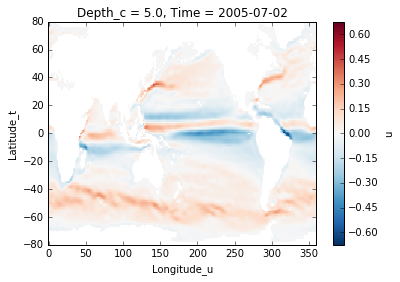

In [12]:
print lon_u, lon_t
print lat_v, lat_t
xray.plot.imshow((.5*(u.roll(Longitude_u=1) + u))[0])

In [16]:
u_coinT = xray.DataArray((.5*(u.roll(Longitude_u=-1) + u)),
                      coords=theta.coords, dims=theta.dims)
v_coinT = xray.DataArray((.5*(v.roll(Latitude_v=-1) + v)),
                      coords=theta.coords, dims=theta.dims)
# print u, u_coinT

## Gulf Stream

In [17]:
GS = np.array([299.5, 39.5])
u_GS = u_coinT.sel(Longitude_t=GS[0], Latitude_t=GS[1])
v_GS = v_coinT.sel(Longitude_t=GS[0], Latitude_t=GS[1])

In [18]:
absS_GS = absS_meta.sel(Longitude_t=GS[0], Latitude_t=GS[1])
consT_GS = consT_meta.sel(Longitude_t=GS[0], Latitude_t=GS[1])
rho_GS = rho_anom.sel(Longitude_t=GS[0], Latitude_t=GS[1])
potrho_GS = potrho_meta.sel(Longitude_t=GS[0], Latitude_t=GS[1])

In [19]:
N2_GS = N2_meta.sel(Longitude_t=GS[0], Latitude_t=GS[1])
zN2_GS = zN2_meta.sel(Longitude_t=GS[0], Latitude_t=GS[1])

In [18]:
print absS_GS, consT_GS
print u_GS, v_GS, N2_GS

<xarray.DataArray (Depth_c: 50)>
array([ 36.37705617,  36.38829268,  36.43808331,  36.49948204,
        36.53953381,  36.55776704,  36.56630143,  36.57135183,
        36.57744907,  36.57823244,  36.57765099,  36.57286845,
        36.56452534,  36.55226472,  36.53229802,  36.50537004,
        36.46777153,  36.41438766,  36.34106086,  36.24866002,
        36.1329151 ,  35.98797394,  35.82308989,  35.66429781,
        35.51827826,  35.39446247,  35.29708428,  35.22529779,
        35.17724572,  35.15076161,  35.14115192,  35.14007741,
        35.13925532,  35.13451384,  35.12538326,  35.11673309,
        35.11542681,  35.12178446,  35.12816684,  35.12755937,
        35.12004502,  35.11000069,  35.10029747,  35.09019658,
        35.0800635 ,  35.07483442,  35.07510403,  35.07778868,
                nan,          nan])
Coordinates:
    Longitude_t  float32 299.5
  * Depth_c      (Depth_c) float32 5.0 15.0 25.0 35.0 45.0 55.0 65.0 75.005 ...
    Latitude_t   float32 39.5
    Time         date

In [19]:
def model_func(x, A, K, C):
    return A * np.exp(K * x) + C

def fit_exp_linear(x, y, C=0):
    """fit an exponential"""
    y = y - C
    y = np.log(y)
    K, A_log = np.polyfit(x, y, 1)
    A = np.exp(A_log)
    return A, K

In [20]:
u0 = u_GS.values[-3]; v0 = v_GS.values[-3]; N20 = N2_GS.values[-3]

# u_raw = u_GS.values.copy()
# v_raw = v_GS.values.copy()
# u_raw[u_raw<0.] = 1e-3
# v_raw[v_raw<0.] = 1e-3

A, K = fit_exp_linear(z_t.values[:-3], u_GS.values[:-3], C=-5e-3)
u_fit = model_func(z_t.values, A, K, -5e-3)
A, K = fit_exp_linear(z_t.values[:-3], v_GS.values[:-3], C=-5e-3)
v_fit = model_func(z_t.values, A, K, -5e-3)
A, K = fit_exp_linear(-zN2_GS.values[:-3], N2_GS.values[:-3], C=N20)
N2_fit = model_func(-zN2_GS.values, A, K, N20)

In [139]:
print u.sel(Longitude_u=GS[0]-.5, Latitude_t=GS[1]), v.sel(Longitude_t=GS[0], Latitude_v=GS[1]-.5)
print u.sel(Longitude_u=GS[0]+.5, Latitude_t=GS[1]), v.sel(Longitude_t=GS[0], Latitude_v=GS[1]+.5)

<xarray.DataArray 'u' (Depth_c: 50)>
array([ 0.23944686,  0.202685  ,  0.18200348,  0.17409228,  0.16885349,
        0.16435893,  0.16032954,  0.15664397,  0.15308236,  0.14954343,
        0.14679012,  0.14432698,  0.1414368 ,  0.13848211,  0.13460122,
        0.13018939,  0.1244467 ,  0.11745287,  0.10890713,  0.09883665,
        0.08717503,  0.07444824,  0.06123254,  0.04839063,  0.03677421,
        0.0268672 ,  0.01867473,  0.0121845 ,  0.00760518,  0.00489767,
        0.00353413,  0.00285542,  0.0024165 ,  0.00199221,  0.00144401,
        0.0006767 , -0.00030298, -0.00136913, -0.00236471, -0.00318346,
       -0.00376874, -0.00404952, -0.00395442, -0.00351102, -0.00283759,
       -0.00198498, -0.00068925,  0.00059345,         nan,         nan])
Coordinates:
    Longitude_u  float32 299.0
  * Depth_c      (Depth_c) float32 5.0 15.0 25.0 35.0 45.0 55.0 65.0 75.005 ...
    Latitude_t   float32 39.5
    Time         datetime64[ns] 2005-07-02
Attributes:
    units: m/s             
    l

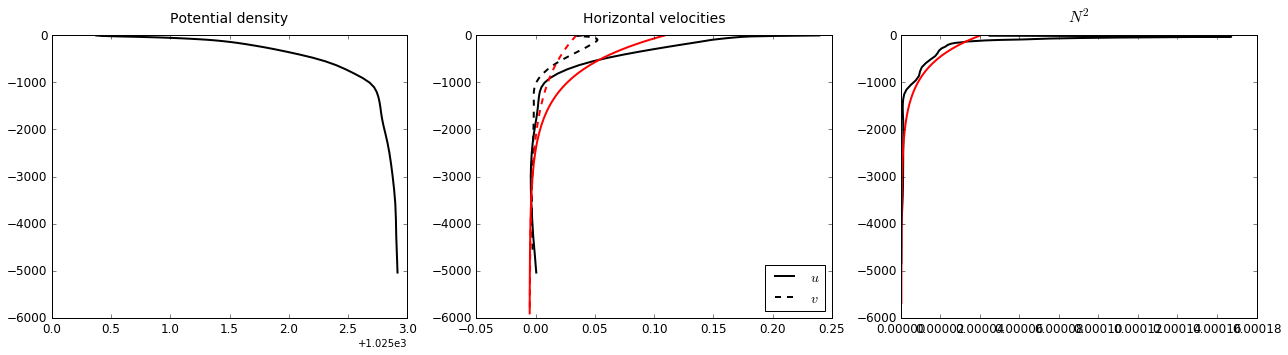

In [22]:
fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(131)
ax1.plot(potrho_GS.values, -z_t.values, 'k', lw=2)
ax1.set_title('Potential density', fontsize=14, y=1.03)
# ax1.set_xlabel('lon', fontsize=12)
# ax1.set_ylabel('lat', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax2 = fig.add_subplot(132)
ax2.plot(u_GS.values, -z_t.values, 'k', lw=2, label=r'$u$')
ax2.plot(v_GS.values, -z_t.values, 'k--', lw=2, label=r'$v$')
ax2.plot(u_fit, -z_t.values, 'r', lw=2)
ax2.plot(v_fit, -z_t.values, 'r--', lw=2)
ax2.set_title('Horizontal velocities', fontsize=14, y=1.03)
# ax2.set_xlabel('lon', fontsize=12)
# ax2.set_ylabel('lat',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=14)

ax3 = fig.add_subplot(133)
ax3.plot(N2_GS.values, zN2_GS.values, 'k', lw=2)
ax3.plot(N2_fit, zN2_GS.values, 'r', lw=2)
ax3.set_title(r'$N^2$', fontsize=16, y=1.03)
# ax1.set_xlabel('lon', fontsize=12)
# ax1.set_ylabel('lat', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

In [21]:
zphi, Rd_GS, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_GS.values, 
                                                        N2_GS.values, f0_meta.sel(Latitude_t=GS[1]).values)

In [26]:
np.savez('OCCA_global',
        absolute_salinity=absS, conservative_temperature=consT,
        potential_density=potrho_meta, 
        z_N2=zN2_meta, N2=N2_meta,
        u_at_Tpoints=u_coinT, v_at_Tpoints=v_coinT,
        z_u=z_t
        )

[  2.02595962e+11   2.57873859e+04   1.39004971e+04   9.60806512e+03
   6.90666297e+03   5.87640200e+03] (48,) [-0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757
 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757
 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757
 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757
 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757
 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757
 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757
 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757] [ 0.2287108   0.22844163  0.22738221  0.22538205  0.22315635  0.22100572
  0.21890111  0.21681132  0.21466035  0.21249153  0.21051281  0.20857709
  0.20653185  0.20436013  0.20172795  0.19864415  0.19475028  0.18960952
  0.18268901  0.17391394  0.16270843  0.14845062  0.13133273  0.11305419
  0.09473064

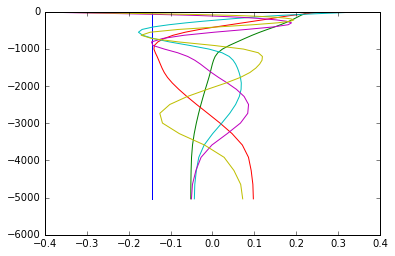

In [88]:
print Rd_GS, zphi.shape, vd[:, 0], vd[:, 1]
plt.figure()
for i in range(vd.shape[1]):
    plt.plot(vd[:, i], -zphi)

In [31]:
np.savez('OCCA_GulfStream',
        absolute_salinity=absS_GS.values, conservative_temperature=consT_GS.values,
        potential_density=potrho_GS.values, 
        z_N2=zN2_GS.values, N2=N2_GS.values,
        u_at_Tpoints=u_GS.values, v_at_Tpoints=v_GS.values, z_u=z_t.values,
        f0=f0_meta.sel(Latitude_t=GS[1]).values, beta=beta_meta.sel(Latitude_t=GS[1]).values,
        Rossby_radii=Rd_GS
        )

In [39]:
print N2_GS.values

[  4.49013733e-05   1.32619531e-04   1.67213349e-04   1.39980381e-04
   1.08620176e-04   8.89353316e-05   7.59696940e-05   6.85660114e-05
   6.13053056e-05   4.96623307e-05   4.26153730e-05   3.83933836e-05
   3.33244718e-05   3.14573673e-05   2.74780120e-05   2.50869570e-05
   2.35907064e-05   2.26047540e-05   2.06309696e-05   1.93499569e-05
   1.85802260e-05   1.73887368e-05   1.49995125e-05   1.25945779e-05
   1.06210281e-05   9.69791903e-06   9.18845407e-06   7.56655382e-06
   5.00383224e-06   2.83633215e-06   1.67170878e-06   1.19350982e-06
   9.87252978e-07   9.54096555e-07   1.05979705e-06   1.18957478e-06
   1.23432375e-06   1.22190029e-06   1.20084648e-06   1.18287498e-06
   1.14801849e-06   1.08643614e-06   9.36511867e-07   6.17342678e-07
   3.35507108e-07   3.19646379e-07   2.60733349e-07              nan
              nan]


In [89]:
dx_GS = gsw.earth.distance([GS[0]-.5,GS[0]+.5], [GS[1],GS[1]])[0][0]
dy_GS = gsw.earth.distance([GS[0],GS[0]], [GS[1]-.5,GS[1]+.5])[0][0]
dx = 1e3; dy = 1e3
Nx_GS = 100
Ny_GS = 100
k = fft.fftshift( fft.fftfreq(Nx_GS, dx) )
l = fft.fftshift( fft.fftfreq(Ny_GS, dy) )

k_GS = k[np.absolute(k) < 5.*Rd_GS[1]**-1]
l_GS = l[np.absolute(l) < 5.*Rd_GS[1]**-1]

In [90]:
print (2*dx_GS)**-1, 5.*Rd_GS[1]**-1, (Nx_GS*dx_GS)**-1
print k_GS.shape, k.shape

5.82748556522e-06 0.000193893247747 1.16549711304e-07
(39,) (100,)


In [24]:
print u_GS.shape, v_GS.shape, dx_GS, dy_GS, zN2_GS.shape
print zN2_GS

(50,) (50,) 85800.2983284 111194.926645 (49,)
<xarray.DataArray (Depth_c: 49)>
array([  -10.00006115,   -20.00006114,   -30.00006113,   -40.00006112,
         -50.0000611 ,   -60.00006109,   -70.00256358,   -80.01506451,
         -90.06006328,  -100.20256308,  -110.5900682 ,  -121.51007976,
        -133.44509256,  -147.10512803,  -163.43519352,  -183.5678012 ,
        -208.72298023,  -240.09073926,  -278.70109317,  -325.30655719,
        -380.30712264,  -443.70276088,  -515.09343642,  -593.72659767,
        -678.57216844,  -768.44015906,  -862.11055267,  -958.45325725,
       -1056.53586028, -1155.72595435, -1255.87608991, -1357.68378579,
       -1463.12934261, -1575.64299213, -1699.66489761, -1839.65538686,
       -1999.10931291, -2180.15155508, -2383.76440293, -2610.28273438,
       -2859.78914881, -3132.29607118, -3427.80347989, -3746.3113517 ,
       -4087.81966191, -4452.32838443, -4839.83749199, -5250.34695635,
       -5683.85674858])
Coordinates:
    Longitude_t  float32 299.5
 

In [27]:
etax = np.zeros(2)
etay = np.zeros(2)
# kwargs = {'v0':np.ones(len(zN2_GS)+1), 'num_Lanczos':int(1e10), 'iteration':int(1e7), 'tol':1e-5}

### Exponential profiles

#### w/out lateral viscosity

In [134]:
zpsi, w, psi = baroclinic.instability_analysis_from_N2_profile( -zN2_GS.values, 
                                                                   N2_fit, f0_meta.sel(Latitude_t=GS[1]).values,
                                                                   beta_meta.sel(Latitude_t=GS[1]).values,
                                                                   k_GS, l_GS, z_t.values, u_fit, v_fit, etax, etay,
                                                                   Ah=0., num=2 )

In [135]:
print w[0].shape, np.argmax(w.imag[0]), psi[:, 0].shape

(39, 39) 681 (50, 39, 39)


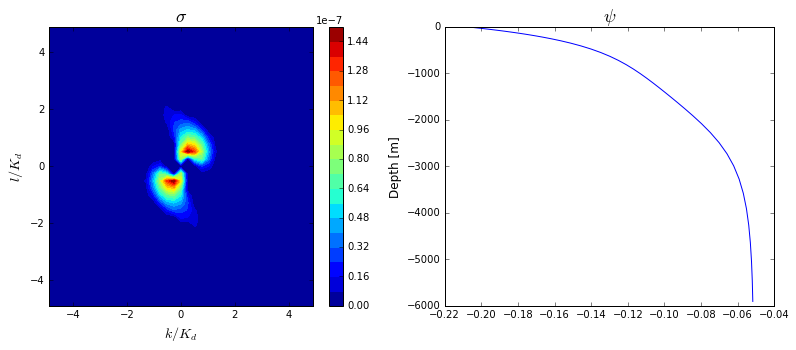

In [136]:
fig = plt.figure(figsize=(13,5))

ax1 = fig.add_subplot(121)
cax = ax1.contourf(k_GS*Rd_GS[1], l_GS*Rd_GS[1], w.imag[0], 20)
cbar = fig.colorbar(cax, orientation='vertical')
ax1.set_xlabel(r'$k/K_d$', fontsize=14)
ax1.set_ylabel(r'$l/K_d$', fontsize=14)
ax1.set_title(r'$\sigma$', fontsize=18)

ax2 = fig.add_subplot(122)
ax2.plot(np.reshape(psi[:, 0], (len(zpsi), psi.shape[-1]**2))[:, np.argmax(w.imag[0])], -zpsi)
ax2.set_ylabel(r'Depth [m]', fontsize=12)
ax2.set_title(r'$\psi$', fontsize=18)

#### w/ lateral viscosity

In [94]:
zpsi, w, psi = baroclinic.instability_analysis_from_N2_profile( -zN2_GS.values, 
                                                                   N2_fit, f0_meta.sel(Latitude_t=GS[1]).values,
                                                                   beta_meta.sel(Latitude_t=GS[1]).values,
                                                                   k_GS, l_GS, z_t.values, u_fit, v_fit, etax, etay,
                                                                   Ah=1e1, num=2 )

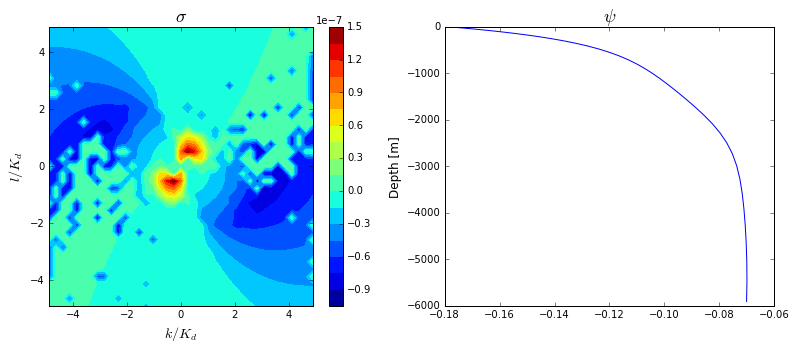

In [95]:
fig = plt.figure(figsize=(13,5))

ax1 = fig.add_subplot(121)
cax = ax1.contourf(k_GS*Rd_GS[1], l_GS*Rd_GS[1], w.imag[0], 20)
cbar = fig.colorbar(cax, orientation='vertical')
ax1.set_xlabel(r'$k/K_d$', fontsize=14)
ax1.set_ylabel(r'$l/K_d$', fontsize=14)
ax1.set_title(r'$\sigma$', fontsize=18)

ax2 = fig.add_subplot(122)
ax2.plot(np.reshape(psi[:, 0], 
                    (len(zpsi), psi.shape[-1]**2))[:, np.argmax(w.imag[0])], -zpsi)
ax2.set_ylabel(r'Depth [m]', fontsize=12)
ax2.set_title(r'$\psi$', fontsize=18)

### Actual profile
#### w/out lateral viscosity ($A_h=0$)

In [105]:
zpsi, w, psi = baroclinic.instability_analysis_from_N2_profile( -zN2_GS.values, 
                                                                   N2_GS.values, f0_meta.sel(Latitude_t=GS[1]).values,
                                                                   beta_meta.sel(Latitude_t=GS[1]).values,
                                                                   k_GS, l_GS, z_t.values, u_GS.values, v_GS.values, etax, etay,
                                                                   Ah=0., num=2 )

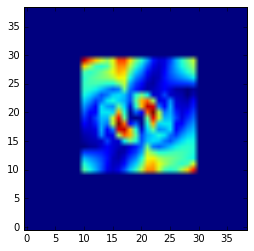

In [109]:
sig = w[0].copy()
for i in range(10):
    sig[:, i] = np.nan
for j in range(10):
    sig[j, :] = np.nan

for i in range(-1,-10,-1):
    sig[:, i] = np.nan
for j in range(-1,-10,-1):
    sig[j, :] = np.nan

plt.imshow(sig.imag, origin='bottom')

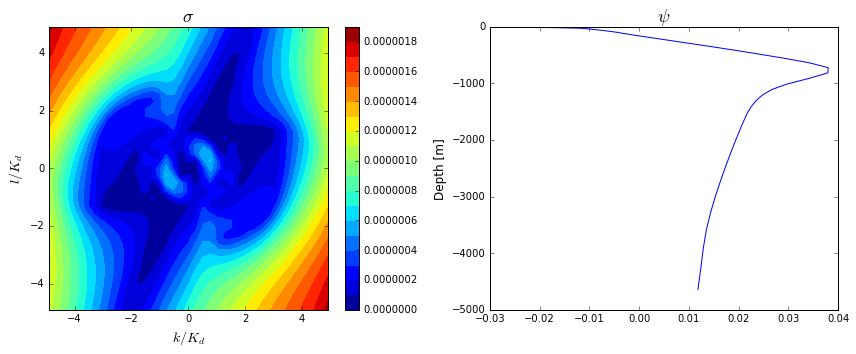

In [111]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
cax = ax1.contourf(k_GS*Rd_GS[1], l_GS*Rd_GS[1], w.imag[0], 20)
cbar = fig.colorbar(cax, orientation='vertical')
ax1.set_xlabel(r'$k/K_d$', fontsize=14)
ax1.set_ylabel(r'$l/K_d$', fontsize=14)
ax1.set_title(r'$\sigma$', fontsize=18)

ax2 = fig.add_subplot(122)
ax2.plot(np.reshape(psi[:, 0], (len(zpsi), 
                                psi.shape[-1]**2))[:, np.nanargmax(sig.imag)], -zpsi)
ax2.set_ylabel(r'Depth [m]', fontsize=12)
ax2.set_title(r'$\psi$', fontsize=18)

plt.tight_layout()

#### w/ lateral viscosity ($A_h=10$)

In [112]:
zpsi, w, psi = baroclinic.instability_analysis_from_N2_profile( -zN2_GS.values, 
                                                                   N2_GS.values, f0_meta.sel(Latitude_t=GS[1]).values,
                                                                   beta_meta.sel(Latitude_t=GS[1]).values,
                                                                   k_GS, l_GS, z_t.values, u_GS.values, v_GS.values, etax, etay,
                                                                   Ah=1e1, num=2 )

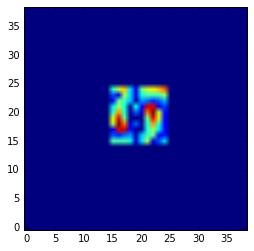

In [116]:
sig = w[0].copy()
for i in range(15):
    sig[:, i] = np.nan
for j in range(15):
    sig[j, :] = np.nan

for i in range(-1,-15,-1):
    sig[:, i] = np.nan
for j in range(-1,-15,-1):
    sig[j, :] = np.nan

plt.imshow(sig.imag, origin='bottom')

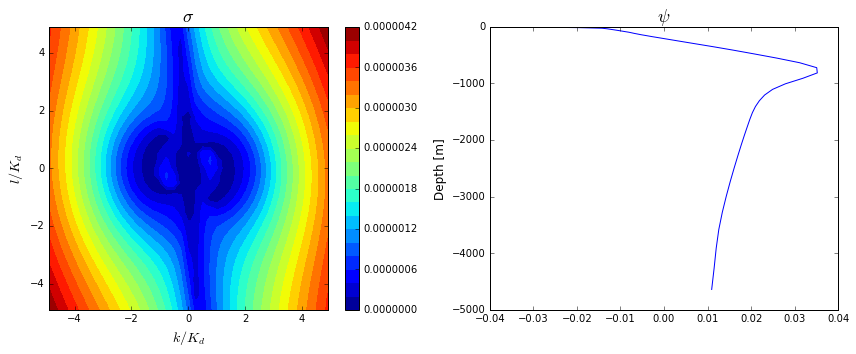

In [117]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
cax = ax1.contourf(k_GS*Rd_GS[1], l_GS*Rd_GS[1], w.imag[0], 20)
cbar = fig.colorbar(cax, orientation='vertical')
ax1.set_xlabel(r'$k/K_d$', fontsize=14)
ax1.set_ylabel(r'$l/K_d$', fontsize=14)
ax1.set_title(r'$\sigma$', fontsize=18)

ax2 = fig.add_subplot(122)
ax2.plot(np.reshape(psi[:, 0], (len(zpsi), psi.shape[-1]**2))[:, np.nanargmax(sig.imag)], -zpsi)
ax2.set_ylabel(r'Depth [m]', fontsize=12)
ax2.set_title(r'$\hat{\psi}(z)$', fontsize=18)

plt.tight_layout()

## ACC

In [45]:
ACC = np.array([141.5, -51.5])
u_ACC = u_coinT.sel(Longitude_t=ACC[0], Latitude_t=ACC[1])
v_ACC = v_coinT.sel(Longitude_t=ACC[0], Latitude_t=ACC[1])

In [46]:
absS_ACC = absS_meta.sel(Longitude_t=ACC[0], Latitude_t=ACC[1])
consT_ACC = consT_meta.sel(Longitude_t=ACC[0], Latitude_t=ACC[1])
rho_ACC = rho_anom.sel(Longitude_t=ACC[0], Latitude_t=ACC[1])
potrho_ACC = potrho_meta.sel(Longitude_t=ACC[0], Latitude_t=ACC[1])

In [47]:
N2_ACC = N2_meta.sel(Longitude_t=ACC[0], Latitude_t=ACC[1])
zN2_ACC = zN2_meta.sel(Longitude_t=ACC[0], Latitude_t=ACC[1])

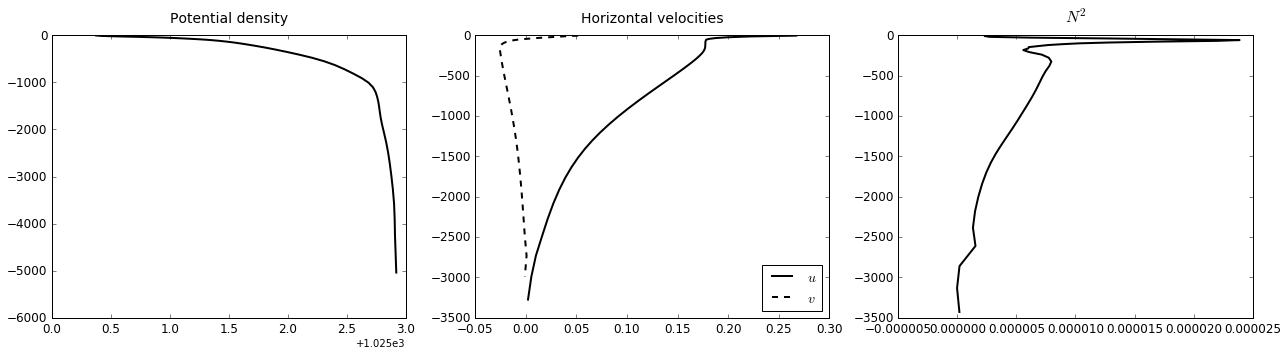

In [48]:
fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(131)
ax1.plot(potrho_GS.values, -z_t.values, 'k', lw=2)
ax1.set_title('Potential density', fontsize=14, y=1.03)
# ax1.set_xlabel('lon', fontsize=12)
# ax1.set_ylabel('lat', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax2 = fig.add_subplot(132)
ax2.plot(u_ACC.values, -z_t.values, 'k', lw=2, label=r'$u$')
ax2.plot(v_ACC.values, -z_t.values, 'k--', lw=2, label=r'$v$')
ax2.set_title('Horizontal velocities', fontsize=14, y=1.03)
# ax2.set_xlabel('lon', fontsize=12)
# ax2.set_ylabel('lat',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=14)

ax3 = fig.add_subplot(133)
ax3.plot(N2_ACC.values, zN2_ACC.values, 'k', lw=2)
ax3.set_title(r'$N^2$', fontsize=16, y=1.03)
# ax1.set_xlabel('lon', fontsize=12)
# ax1.set_ylabel('lat', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

In [80]:
zphi, Rd_ACC, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_ACC.values, 
                                                        N2_ACC.values, f0_meta.sel(Latitude_t=ACC[1]).values)

In [50]:
np.savez('OCCA_ACC',
        absolute_salinity=absS, conservative_temperature=consT,
        potential_density=potrho_meta, 
        z_N2=zN2_meta, N2=N2_meta,
        u_at_Tpoints=u_coinT, v_at_Tpoints=v_coinT
        )

[            nan  17723.58428203   8362.66058973   5565.62704798
   4140.69532059   3297.01669271] (44,) [ 0.15075567  0.15075567  0.15075567  0.15075567  0.15075567  0.15075567
  0.15075567  0.15075567  0.15075567  0.15075567  0.15075567  0.15075567
  0.15075567  0.15075567  0.15075567  0.15075567  0.15075567  0.15075567
  0.15075567  0.15075567  0.15075567  0.15075567  0.15075567  0.15075567
  0.15075567  0.15075567  0.15075567  0.15075567  0.15075567  0.15075567
  0.15075567  0.15075567  0.15075567  0.15075567  0.15075567  0.15075567
  0.15075567  0.15075567  0.15075567  0.15075567  0.15075567  0.15075567
  0.15075567  0.15075567] [ 0.20222925  0.20221197  0.20218506  0.20209236  0.20183898  0.2013884
  0.20068079  0.19992397  0.19926578  0.19869092  0.19816759  0.19765314
  0.19712988  0.1965532   0.19590214  0.19503075  0.19390261  0.19216506
  0.18926727  0.1848589   0.17860189  0.17035836  0.16001848  0.14743217
  0.1326062   0.11582929  0.09762903  0.07867682  0.05962827  0.041

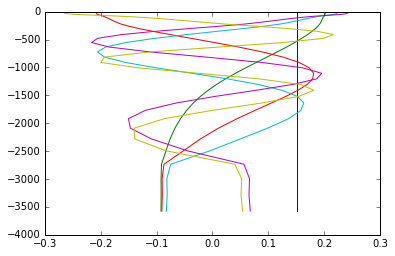

In [81]:
print Rd_ACC, zphi.shape, vd[:, 0], vd[:, 1]
plt.figure()
for i in range(vd.shape[1]):
    plt.plot(vd[:, i], -zphi)

In [82]:
dx_ACC = gsw.earth.distance([ACC[0]-.5,ACC[0]+.5], [ACC[1],ACC[1]])[0][0]
dy_ACC = gsw.earth.distance([ACC[0],ACC[0]], [ACC[1]-.5,ACC[1]+.5])[0][0]
dx = 6e2; dy = 6e2
Nx_ACC = 100
Ny_ACC = 100
k = fft.fftshift( fft.fftfreq(Nx_ACC, dx) )
l = fft.fftshift( fft.fftfreq(Ny_ACC, dy) )

k_ACC = k[np.absolute(k) < 5.*Rd_ACC[1]**-1]
l_ACC = l[np.absolute(l) < 5.*Rd_ACC[1]**-1]

In [83]:
print k, 5.*Rd_ACC[1]**-1
print k_ACC.shape

[ -8.33333333e-04  -8.16666667e-04  -8.00000000e-04  -7.83333333e-04
  -7.66666667e-04  -7.50000000e-04  -7.33333333e-04  -7.16666667e-04
  -7.00000000e-04  -6.83333333e-04  -6.66666667e-04  -6.50000000e-04
  -6.33333333e-04  -6.16666667e-04  -6.00000000e-04  -5.83333333e-04
  -5.66666667e-04  -5.50000000e-04  -5.33333333e-04  -5.16666667e-04
  -5.00000000e-04  -4.83333333e-04  -4.66666667e-04  -4.50000000e-04
  -4.33333333e-04  -4.16666667e-04  -4.00000000e-04  -3.83333333e-04
  -3.66666667e-04  -3.50000000e-04  -3.33333333e-04  -3.16666667e-04
  -3.00000000e-04  -2.83333333e-04  -2.66666667e-04  -2.50000000e-04
  -2.33333333e-04  -2.16666667e-04  -2.00000000e-04  -1.83333333e-04
  -1.66666667e-04  -1.50000000e-04  -1.33333333e-04  -1.16666667e-04
  -1.00000000e-04  -8.33333333e-05  -6.66666667e-05  -5.00000000e-05
  -3.33333333e-05  -1.66666667e-05   0.00000000e+00   1.66666667e-05
   3.33333333e-05   5.00000000e-05   6.66666667e-05   8.33333333e-05
   1.00000000e-04   1.16666667e-04

#### w/out lateral viscosity ($A_h=0$)

In [120]:
zpsi, w, psi = baroclinic.instability_analysis_from_N2_profile( -zN2_ACC.values, 
                                                                   N2_ACC.values, f0_meta.sel(Latitude_t=ACC[1]).values,
                                                                   beta_meta.sel(Latitude_t=ACC[1]).values,
                                                                   k_ACC, l_ACC, z_t.values, u_ACC.values, v_ACC.values, etax, etay,
                                                                   Ah=0., num=2 )

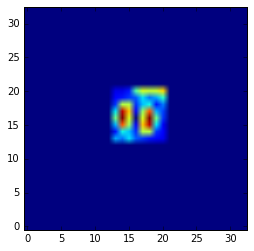

In [124]:
sig = w[0].copy()
for i in range(13):
    sig[:, i] = np.nan
for j in range(13):
    sig[j, :] = np.nan

for i in range(-1,-13,-1):
    sig[:, i] = np.nan
for j in range(-1,-13,-1):
    sig[j, :] = np.nan

plt.imshow(sig.imag, origin='bottom')

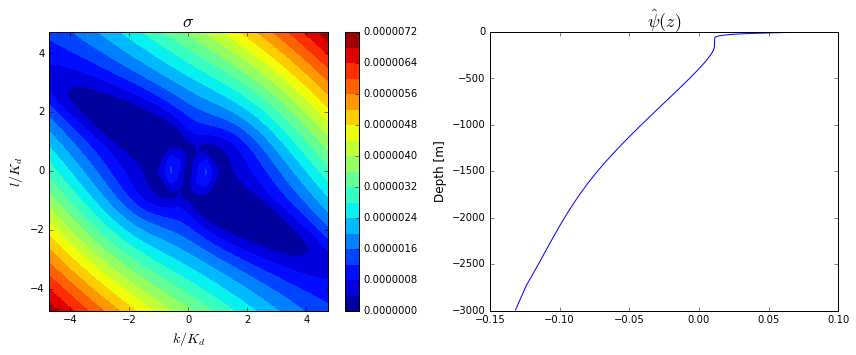

In [126]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
cax = ax1.contourf(k_ACC*Rd_ACC[1], l_ACC*Rd_ACC[1], w.imag[0], 20)
cbar = fig.colorbar(cax, orientation='vertical')
ax1.set_xlabel(r'$k/K_d$', fontsize=14)
ax1.set_ylabel(r'$l/K_d$', fontsize=14)
ax1.set_title(r'$\sigma$', fontsize=18)

ax2 = fig.add_subplot(122)
ax2.plot(np.reshape(psi[:, 0], (len(zpsi), psi.shape[-1]**2))[:, np.nanargmax(sig.imag)], -zpsi)
ax2.set_ylabel(r'Depth [m]', fontsize=12)
ax2.set_title(r'$\hat{\psi}(z)$', fontsize=18)

plt.tight_layout()

#### w/ lateral viscosity ($A_h=10$)

In [129]:
zpsi, w, psi = baroclinic.instability_analysis_from_N2_profile( -zN2_ACC.values, 
                                                                   N2_ACC.values, f0_meta.sel(Latitude_t=ACC[1]).values,
                                                                   beta_meta.sel(Latitude_t=ACC[1]).values,
                                                                   k_ACC, l_ACC, z_t.values, u_ACC.values, v_ACC.values, etax, etay,
                                                                   Ah=1e1, num=2 )

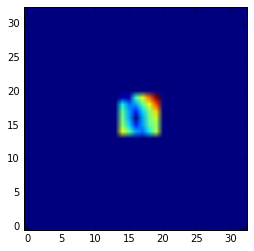

In [132]:
sig = w[0].copy()
for i in range(14):
    sig[:, i] = np.nan
for j in range(14):
    sig[j, :] = np.nan

for i in range(-1,-14,-1):
    sig[:, i] = np.nan
for j in range(-1,-14,-1):
    sig[j, :] = np.nan

plt.imshow(sig.imag, origin='bottom')

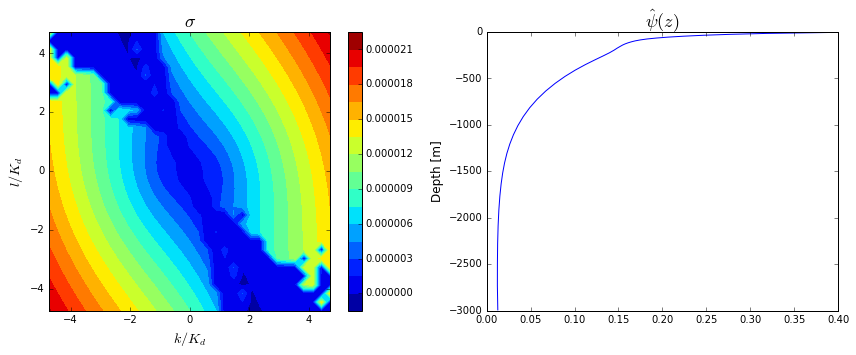

In [133]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
cax = ax1.contourf(k_ACC*Rd_ACC[1], l_ACC*Rd_ACC[1], w.imag[0], 20)
cbar = fig.colorbar(cax, orientation='vertical')
ax1.set_xlabel(r'$k/K_d$', fontsize=14)
ax1.set_ylabel(r'$l/K_d$', fontsize=14)
ax1.set_title(r'$\sigma$', fontsize=18)

ax2 = fig.add_subplot(122)
ax2.plot(np.reshape(psi[:, 0], (len(zpsi), psi.shape[-1]**2))[:, np.nanargmax(sig.imag)], -zpsi)
ax2.set_ylabel(r'Depth [m]', fontsize=12)
ax2.set_title(r'$\hat{\psi}(z)$', fontsize=18)

plt.tight_layout()